# Алешко Альберт АС-21-05 Вариант 1
# Лабораторная работа №4
# Регрессионный анализ 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from itertools import chain
from scipy.stats import spearmanr, f

plt.style.use('Solarize_Light2') # Функция для задания стиля графикам


По данным предыдущей работы провести регрессионный анализ:

выбрать вид регрессионной зависимости (возможно преобразование данных для выбора линейной модели); 

определить модельные коэффициенты;

проверить модель на значимость;

провести проверку модели на адекватность (см. дополнительные данные на отдельной вкладке).


In [2]:
names = [f'var{i + 1}' for i in range(5)]

df_train = pd.read_excel('data2.xlsx', sheet_name='2-1',
                   header=None, names=names)
df_train.head(6)

,var1,var2,var3,var4,var5
0,13.576533,8.444634,42.737,7.574,2.369
1,9.988142,13.552947,23.261,1.660,6.072
2,8.190783,14.466266,13.439,-5.422,3.504
3,8.412009,10.531638,15.174,-5.483,4.532
4,10.021344,8.826599,24.573,3.247,7.447
5,6.843471,7.619135,13.896,-5.045,7.473


In [3]:
df_test = pd.read_excel('data2.xlsx', sheet_name='1вар-адекв',
                   header=None, names=names)
df_test.head(6)

,var1,var2,var3,var4,var5
0,8,10.746,19.059,-1.541,6.924
1,8,10.220,16.557,-4.043,5.923
2,8,8.615,18.565,-2.035,6.726
3,8,4.791,18.115,-2.485,6.546
4,8,2.831,19.900,-0.700,7.260
5,9,5.483,21.785,-1.115,5.225


In [4]:
independent_var = 'var1'

y_train = df_train[[var for var in df_train.columns if var != independent_var]]
x_train = df_train[independent_var]
y_test = df_test[y_train.columns]
x_test = df_test[independent_var]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50,), (50, 4), (35,), (35, 4))

In [5]:
def plot_data(x, y):
    fig, axs = plt.subplots(y.shape[1]//2, y.shape[1]//2, figsize=(10, 10))

    axs = list(chain.from_iterable(axs))

    for name, ax in zip(y_train.columns, axs):
        res = spearmanr(x, y[name])
        sns.regplot(x=x, y=y[name], ax=ax)
        ax.set_ylabel(name)
        ax.set_xlabel(independent_var)
        ax.text(x.min(), y[name].max(), 
                f'corr: {res[0]:.2f}, p-val: {res[1]:.2f}')

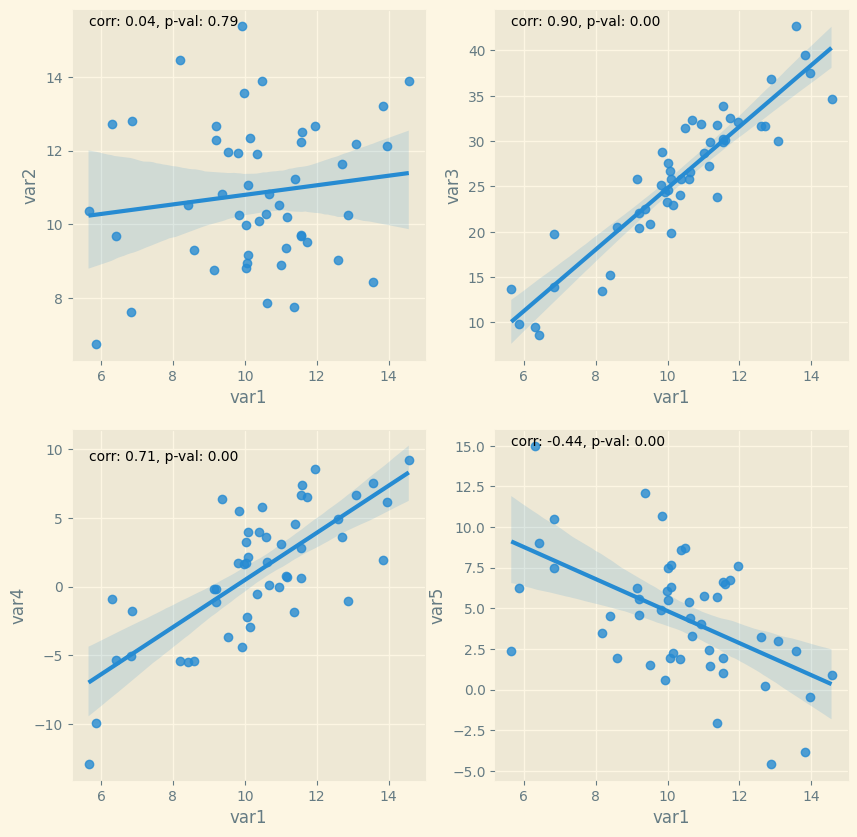

In [6]:
plot_data(x_train, y_train)

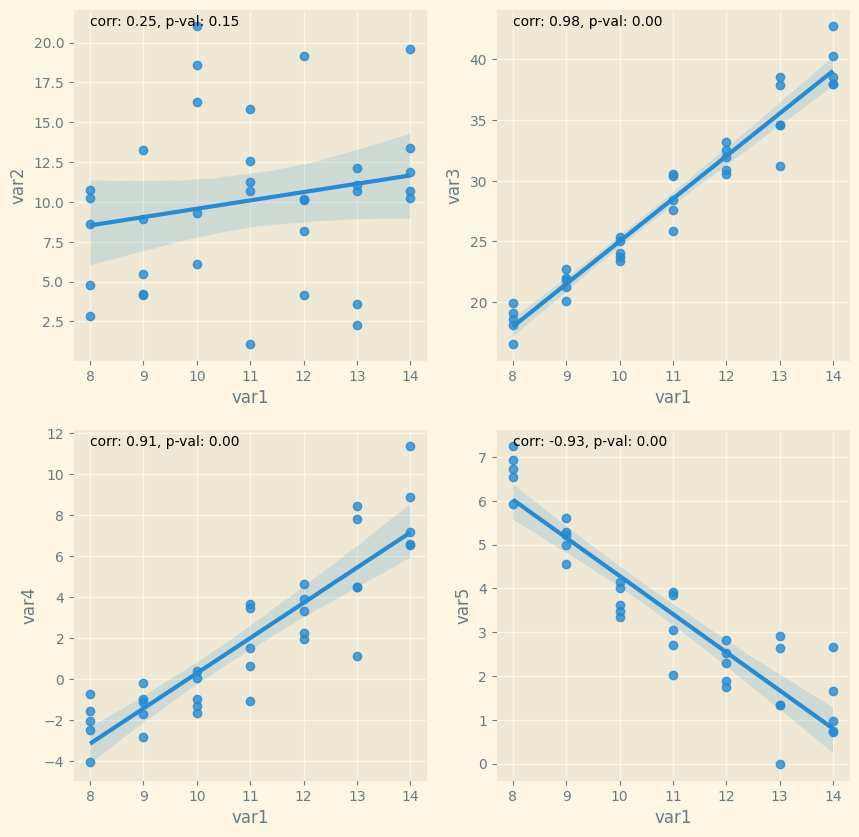

In [7]:
plot_data(x_test, y_test)

var1 - var2 - независимые

var1 - var3 - линейная зависимость

var1 - var4 - экспоненциальная зависимость (предположительно)

var1 - var5 - обратная экспоненциальная зависимость (предположительно)


С целью преобразования экспоненциальная зависимости в линейную, выполним преобразование: $x' = log(1 + x - min)$

где min = min(x),
max = max(x)

In [8]:
# var4_min = y_train['var4'].min()
var5_min = y_train['var5'].min()
# y_train.loc[:, 'var4'] = np.power(y_train['var4'] - var4_min, 0.95).values
y_train.loc[:, 'var5'] = np.log(1 + np.exp(y_train['var5']) - np.exp(y_train['var5']).min()).values
# y_test.loc[:, 'var4'] = np.power(y_test['var4'] - y_test['var4'].min(), 0.95).values
y_test.loc[:, 'var5'] = np.log(1 + np.exp(y_test['var5'] - y_test['var5'].min()) - np.exp(y_test['var5'] - y_test['var5'].min()).min()).values

В итоге, после проведённых испытаний, получилось следующее

первые 2 прогноза остались

var1 - var4 - линейная зависимость

var1 - var5 - сложная зависимость


С целью преобразования зависимости в линейную, я выполнил преобразование: $x' = log(1 + e^{(x - min)} - min_e)$

где $min = min(x)$,<br>
$min_e = min(exp(x))$.

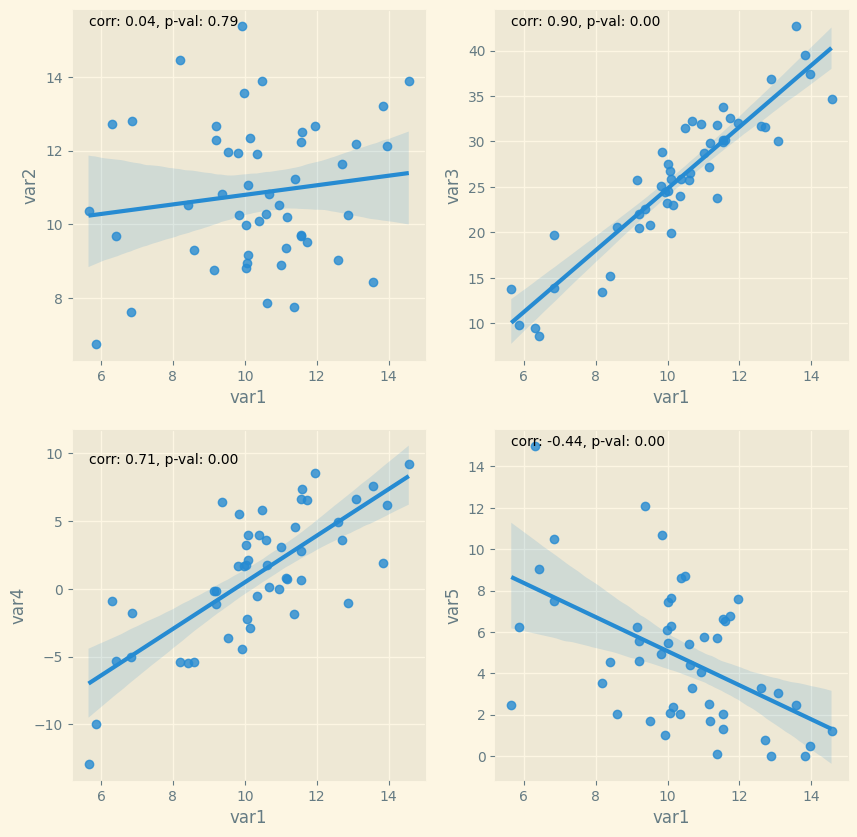

In [9]:
plot_data(x_train, y_train)

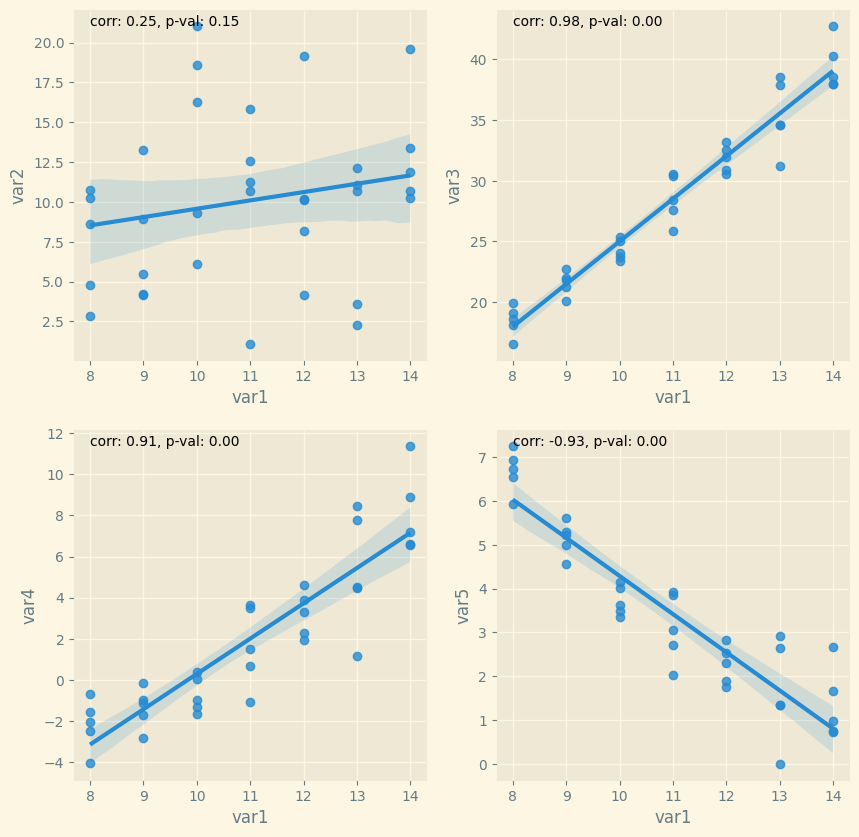

In [10]:
plot_data(x_test, y_test)

In [11]:
def get_means(x_test, y_test):
    means = dict()
    for x in x_test.unique():
        means[x] = np.mean(y_test[x_test == x])
    
    def f(x):
        nonlocal means, x_test
        return means[x], (x_test == x).sum()
    return f

In [12]:
def is_adequately(linear_model, x_test, y_test):
    n = 30
    m = 6
    f_means = get_means(x_test, y_test)
    x_test_unique = x_test.unique()
    preds = linear_model.predict(pd.Series(x_test_unique, name='var1'))
    Q2 = 0
    for x, pred in zip(x_test_unique, preds):
        mean, n_i = f_means(x)
        Q2 += n_i * (mean - pred) ** 2

    Q3 = 0
    mean = y_test_part.mean()
    for y in y_test_part:
        Q3 += (mean - y) ** 2

    t = Q2 * (n - m) / (Q3 * (m - 2))
    tcr = f.ppf(0.95, m-2, n-m)
    
    print(f'{t = :.2f}, {tcr = :.2f}')

    return t < tcr

In [13]:
target_var = 'var2'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var2   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9459
Date:                Sun, 19 May 2024   Prob (F-statistic):              0.336
Time:                        14:07:27   Log-Likelihood:                -102.82
No. Observations:                  50   AIC:                             209.6
Df Residuals:                      48   BIC:                             213.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5047      1.406      6.762      0.000       6.679      12.331
var1           0.1297      0.133      0.973      0.336      -0.138       0.398
==============================================================================
Omnibus:                        1.183   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.554   Jarque-Bera (JB):                1.146
Skew:                           0.235   Prob(JB):                        0.564
Kurtosis:                       2.426   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
is_adequately(linear_model, x_test, y_test_part)

t = 1.64, tcr = 2.78


True

In [15]:
target_var = 'var3'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var3   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     258.8
Date:                Sun, 19 May 2024   Prob (F-statistic):           5.76e-21
Time:                        14:07:27   Log-Likelihood:                -125.74
No. Observations:                  50   AIC:                             255.5
Df Residuals:                      48   BIC:                             259.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.1250      2.223     -4.105      0.000     -13.595      -4.656
var1           3.3935      0.211     16.086      0.000       2.969       3.818
==============================================================================
Omnibus:                        0.422   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.567
Skew:                          -0.008   Prob(JB):                        0.753
Kurtosis:                       2.478   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
is_adequately(linear_model, x_test, y_test_part)

t = 0.03, tcr = 2.78


True

In [17]:
target_var = 'var4'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var4   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     61.17
Date:                Sun, 19 May 2024   Prob (F-statistic):           4.11e-10
Time:                        14:07:27   Log-Likelihood:                -127.77
No. Observations:                  50   AIC:                             259.5
Df Residuals:                      48   BIC:                             263.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.7060      2.315     -7.215      0.000     -21.361     -12.051
var1           1.7185      0.220      7.821      0.000       1.277       2.160
==============================================================================
Omnibus:                        0.920   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.841
Skew:                          -0.015   Prob(JB):                        0.657
Kurtosis:                       2.366   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
is_adequately(linear_model, x_test, y_test_part)

t = 0.21, tcr = 2.78


True

In [19]:
target_var = 'var5'
y_test_part = y_test[target_var]

model_linear_ols = smf.ols(formula=f'{target_var} ~ var1', data=df_train)
linear_model = model_linear_ols.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var5   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     19.14
Date:                Sun, 19 May 2024   Prob (F-statistic):           6.53e-05
Time:                        14:07:27   Log-Likelihood:                -129.05
No. Observations:                  50   AIC:                             262.1
Df Residuals:                      48   BIC:                             265.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.6881      2.375      6.184      0.000       9.912      19.464
var1          -0.9861      0.225     -4.375      0.000      -1.439      -0.533
==============================================================================
Omnibus:                        0.209   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.411
Skew:                          -0.003   Prob(JB):                        0.814
Kurtosis:                       2.556   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
is_adequately(linear_model, x_test, y_test_part)

t = 0.67, tcr = 2.78


True